In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
pd.set_option("display.max_rows", 100)

In [29]:
def get_clean_data(stock_list, start, end, period='1D'): # Download and clean data from yahoo finance
    data = yf.Tickers(stock_list)
    data = data.history(start=start, end=end)['Close']
    data.sort_index(inplace=True)
    data.ffill(axis=0, inplace=True)
    return data

In [32]:
def efficient_frontier(cov_matrix, mean_daily_returns, num_portfolios, risk_free_rate=0):
    results = np.zeros((len(stocks) + 3, num_portfolios))  # Need +3 columns to sharpe, expected returns and volatility
    
    for i in range(num_portfolios):
        weights = np.array(np.random.random(len(cov_matrix)))  # Create a array with random weights from 0.0 to 1.0
        weights /= np.sum(weights)  # Divide by the sum of weights to make sum of array equals to 1.0

        portfolio_return = np.sum(mean_daily_returns *  weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252) # Annualized std deviation (volatility)
        
        results[0, i] = portfolio_return
        results[1, i] = portfolio_std_dev
        results[2, i] = (results[0, i] - risk_free_rate)/ results[1, i] # Sharpe ratio formula
        
        for j in range(len(weights)):
            results[j+3, i] = weights[j]

In [36]:
end = dt.datetime(2022,1,1)
start = dt.datetime(2015,1,1)
stocks = ['AAPL','GOOG','AMZN','NVDA']
df = get_clean_data(stocks, start, end)
df

[*********************100%***********************]  4 of 4 completed


,AAPL,AMZN,GOOG,NVDA
Date,,,,
2015-01-02 00:00:00-05:00,24.603210,15.426000,26.168653,4.834949
2015-01-05 00:00:00-05:00,23.910099,15.109500,25.623152,4.753286
2015-01-06 00:00:00-05:00,23.912346,14.764500,25.029282,4.609173
2015-01-07 00:00:00-05:00,24.247646,14.921000,24.986401,4.597166
2015-01-08 00:00:00-05:00,25.179295,15.023000,25.065184,4.770098
...,...,...,...,...
2021-12-27 00:00:00-05:00,179.289459,169.669495,148.063995,309.160919
2021-12-28 00:00:00-05:00,178.255447,170.660995,146.447998,302.936707
2021-12-29 00:00:00-05:00,178.344925,169.201004,146.504501,299.729736


In [43]:
returns = df.pct_change().copy()
cov_matrix = returns.cov()
mean_daily_returns = returns.mean()

num_portfolios = 100000

efficient_frontier(cov_matrix, mean_daily_returns, num_portfolios)

col_names = ["Return", "Volatility", "Sharpe"] + stocks.copy()
results_df = pd.DataFrame(results.T)
results_df.columns = [name for name in col_names]

max_sharpe = results_df.iloc[results_df['Sharpe'].idxmax()]  # Return the row of max_sharpe ratio
min_volatility = results_df.iloc[results_df['Volatility'].idxmin()]  # Return the row with minimum volatility 
print("-"*70)
print(f"Portfolio with max sharpe ratio in {num_portfolios} simulations\n{max_sharpe}")
print("-"*70)
print(f"Portfolio with min volatility in {num_portfolios} simulations\n{min_volatility}")  

----------------------------------------------------------------------
Portfolio with max sharpe ratio in 100000 simulations
Return        0.517326
Volatility    0.313802
Sharpe        1.648575
AAPL          0.111898
GOOG          0.417398
AMZN          0.012060
NVDA          0.458644
Name: 6282, dtype: float64
----------------------------------------------------------------------
Portfolio with min volatility in 100000 simulations
Return        0.319414
Volatility    0.242309
Sharpe        1.318208
AAPL          0.304703
GOOG          0.246764
AMZN          0.448255
NVDA          0.000279
Name: 1333, dtype: float64


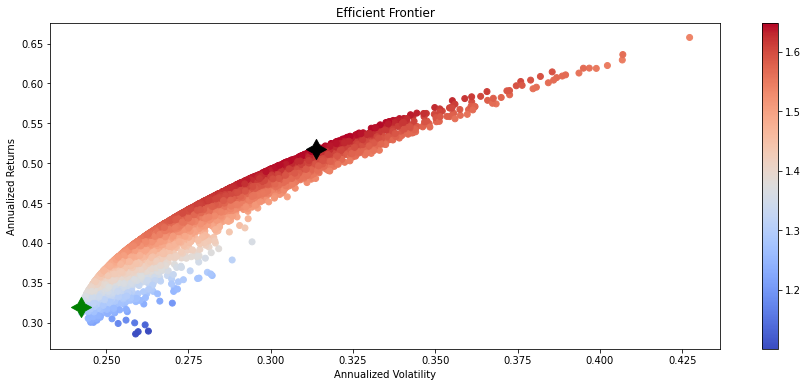

In [44]:
# Plotting efficient frontier
plt.figure(figsize=(15, 6))
plt.scatter(results_df.Volatility, results_df.Return, c=results_df.Sharpe, cmap='coolwarm')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Returns')
plt.title('Efficient Frontier')
plt.colorbar()

plt.scatter(max_sharpe[1], max_sharpe[0], marker = (4,1,0), color='black', s=400)  # Portfolio with maximum sharpe ratio 
plt.scatter(min_volatility[1], min_volatility[0], marker = (4,1,0), color='g', s=400)  # Portfolio with min volatility 
plt.show()